In [ ]:
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"

In [ ]:
pip install tensorflow-gnn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.7/89.7 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.0/152.0 kB 9.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of grpcio-tools to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of grpcio-tools to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 836.

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_gnn as tfgnn

In [ ]:
class DataGen:
    def __init__(self, num_particles: int = 2, masses: np.ndarray = np.zeros(shape=(2,)), orbit_length: int = 1000, dt = 0.01):
        self.num_particles = num_particles
        self.orbit_length = orbit_length
        self.dt = dt
        assert masses.shape == (num_particles,)
        self.masses = masses
        self.source_inds = []
        for i in range(num_particles):
            self.source_inds += [i] * (num_particles - 1)
        # np.random.seed(1)
        self.target_inds = []
        for i in range(num_particles):
            self.target_inds += [x for x in range(num_particles) if x != i]

    def initialize_pos_vel(self):
        # Particle zero is sun, and starts at rest from the origin. Other particles
        # start from random points, each one chosen from well-separated grids to ensure
        # they are not co-incident.
        # We will create N^2 grids to place the particles in. If N is even, we will
        # add one to it to make it odd so that there is a central grid, centered at
        # the origin, where we place the Sun.

        N = np.ceil(np.sqrt(self.num_particles))
        if N % 2 == 0:
            N += 1
        num_rows = int(N)
        xtmp, ytmp = np.zeros(shape=(num_rows, num_rows)),  np.zeros(shape=(num_rows, num_rows))

        for i in range(num_rows):
            bottom = -N/2 + i + 0.1
            top = -N/2 + i + 1 - 0.1
            for j in range(num_rows):
                left = -N/2 + j + 0.1
                right = -N/2 + j + 1 - 0.1
                xtmp[i,j] = np.random.uniform(low=left, high=right)
                ytmp[i,j] = np.random.uniform(low=bottom, high=top)

        grid_size = int(N**2)
        sun_loc = int((N**2 -1)/2)
        xtmp, ytmp = xtmp.reshape((grid_size,)), ytmp.reshape((grid_size,))
        xtmp, ytmp = np.delete(xtmp, [sun_loc]), np.delete(ytmp, [sun_loc])


        selected_grids = np.random.choice(grid_size-1, size=self.num_particles - 1, replace=False)

        gauge = np.sqrt(self.masses + (5 - self.masses)*(self.masses < 5).astype(np.float32))

        x0s =  gauge * np.concatenate((np.array([0]), xtmp[selected_grids]))
        y0s =  gauge * np.concatenate((np.array([0]), ytmp[selected_grids]))


        scale = np.random.uniform(0.1,2, size=(self.num_particles,))
        R_cubes = (np.sqrt(x0s**2 + y0s**2))**3
        R_cubes[0] += 1
        red_masses = self.masses * self.masses[0] / (self.masses + self.masses[0])
        scales = scale * np.sqrt((self.masses[0] / self.masses) * red_masses / R_cubes)
        vx0s = - scales * y0s
        vy0s = scales * x0s


        return x0s, y0s, vx0s, vy0s


    def get_acceleration(self, xs, ys):
        X_broadcast = np.atleast_2d(xs).repeat(repeats=self.num_particles, axis=0)
        X_diffs = X_broadcast - X_broadcast.T
        Y_broadcast = np.atleast_2d(ys).repeat(repeats=self.num_particles, axis=0)
        Y_diffs = Y_broadcast - Y_broadcast.T

        R_cubes = (np.sqrt(X_diffs*X_diffs + Y_diffs*Y_diffs))**3 + np.identity(self.num_particles)

        M_broadcast = np.atleast_2d(self.masses).repeat(repeats=self.num_particles, axis=0)

        axs = np.sum(M_broadcast * X_diffs / R_cubes, axis=1)
        ays = np.sum(M_broadcast * Y_diffs / R_cubes, axis=1)

        return axs, ays


    def leapfrog_int(self, x0s, y0s, vx0s, vy0s):
        ax, ay = self.get_acceleration(x0s, y0s)

        vx_mid = vx0s + 0.5 * self.dt * ax
        x1s = x0s + vx_mid * self.dt

        vy_mid = vy0s + 0.5 * self.dt * ay
        y1s = y0s + vy_mid * self.dt

        ax, ay = self.get_acceleration(x1s, y1s)

        vx1s = vx_mid + 0.5 * self.dt * ax
        vy1s = vy_mid + 0.5 * self.dt * ay

        return x1s, y1s, vx1s, vy1s


    def euler_int(self, x0s, y0s, vx0s, vy0s):
        ax, ay = self.get_acceleration(x0s, y0s)

        vx_1s = vx0s + self.dt * ax
        x1s = x0s + self.dt * vx0s

        vy_1s = vy0s + self.dt * ay
        y1s = y0s + self.dt * vy0s

        return x1s, y1s, vx_1s, vy_1s


    def integrate(self, x_values, y_values, vx_values, vy_values, integration_method = None):
        if not integration_method:
            integration_method = self.euler_int
        for i in range(1, len(x_values)):
            x_values[i], y_values[i], vx_values[i], vy_values[i] = integration_method(
            x_values[i-1], y_values[i-1], vx_values[i-1], vy_values[i-1])

        return x_values, y_values, vx_values, vy_values


    def orbits_collide(self, x_values1, y_values1, x_values2, y_values2):
        x_diffs = x_values1 - x_values2
        y_diffs = y_values1 - y_values2
        r_diffs = np.sqrt(x_diffs**2 + y_diffs**2)
        r_min = min(r_diffs)
        if r_min < 1:
            return True
        else:
            return False


    def gen_orbits(self, num_orbits: int = 3, int_method = None):
        orbits = np.zeros(shape=(num_orbits, self.orbit_length, 4, self.num_particles))
        for i in range(num_orbits):
            check = True
            while check:
                orbits[i][0] = np.array(self.initialize_pos_vel())
                x_values = orbits[i, :, 0, :]
                y_values = orbits[i, :, 1, :]
                vx_values = orbits[i, :, 2, :]
                vy_values = orbits[i, :, 3, :]
                orbits[i] = np.array((self.integrate(x_values, y_values, vx_values, vy_values, integration_method = int_method))).transpose((1,0,2))
                test = True
                for p in range(self.num_particles - 1):
                    for q in range(p+1, self.num_particles):
                        x1s, y1s = orbits[i, :, 0, p], orbits[i, :, 1, p]
                        x2s, y2s = orbits[i, :, 0, q], orbits[i, :, 1, q]
                        if self.orbits_collide(x1s, y1s, x2s, y2s):
                            test = False
                            break
                    if not test:
                        break
                if test:
                    check = False

        return orbits


    def in_out(self, orbits):
        X = orbits[:, :-1, :, :]
        X = X.reshape(-1, X.shape[2], X.shape[3])
        X = X.transpose((0,2,1))

        y = orbits[:, 1:, :, :]
        y = y.reshape(-1, y.shape[2], y.shape[3])
        y = y.transpose((0,2,1))

        return X, y



    def noisy_in_out(self, orbits):
        X, y = self.in_out(orbits)
        stdevs = X.std(axis=0)
        data_size = len(X)
        noisy_size = int(np.floor(0.2*data_size))
        mask = np.random.choice(data_size, noisy_size, replace=False)
        X[mask] = X[mask] + 0.05 * stdevs

        return X, y



    def map_to_graph(self, in_pos_vel, out_pos_vel):
        in_pos = in_pos_vel[ :, 0:2]
        in_vel = in_pos_vel[ :, 2:4]
        masses = self.masses
        label = out_pos_vel
        n = self.num_particles

        graph = tfgnn.GraphTensor.from_pieces(
            node_sets={
                "particles": tfgnn.NodeSet.from_fields(
                    sizes = [n],
                    features = {
                        "position": in_pos,
                        "velocity": in_vel,
                        "mass": masses})},
            edge_sets={
                "interaction": tfgnn.EdgeSet.from_fields(
                    sizes = [n * (n-1)],
                    features = {"g": tf.expand_dims(tf.constant([1.0]), axis=0)},
                    adjacency = tfgnn.Adjacency.from_indices(
                    source = ("particles", self.source_inds),
                    target = ("particles", self.target_inds)))},
            context=tfgnn.Context.from_fields(
                features = {"time_step": tf.constant([self.dt])}))
        return graph, label



    def graph_dataset(self, orbits):
        X, y = self.in_out(orbits)
        dataset = tf.data.Dataset.from_tensor_slices((X, y))
        dataset = dataset.map(self.map_to_graph).shuffle(buffer_size=10000).batch(32)

        return dataset


In [ ]:
test = DataGen(num_particles=3, orbit_length = 1000, masses= np.array([100, 100, 100]), dt=0.01)

In [ ]:
orbits = test.gen_orbits(num_orbits=1)

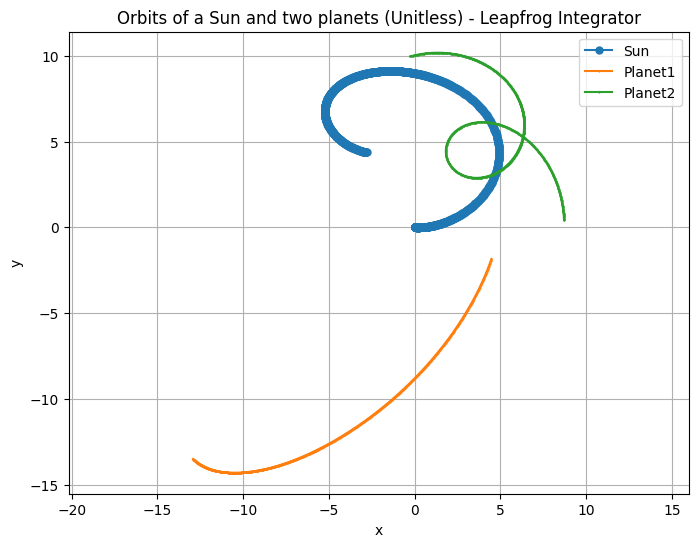

In [ ]:
orbit = orbits[0]
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(orbit[:, 0, 0], orbit[:, 1, 0], marker=".", markersize=10, label='Sun')
plt.plot(orbit[:, 0, 1], orbit[:, 1, 1], marker=".", markersize=1, label='Planet1')
plt.plot(orbit[:, 0, 2], orbit[:, 1, 2], marker=".", markersize=1, label='Planet2')
# plt.plot(orbit[:, 0, 3], orbit[:, 1, 3], marker=".", markersize=1, label='Planet3')
# plt.plot(orbit[:, 0, 4], orbit[:, 1, 4], marker=".", markersize=1, label='Planet2')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Orbits of a Sun and two planets (Unitless) - Leapfrog Integrator')
plt.axis('equal')
plt.legend()
plt.grid(True)
plt.show()

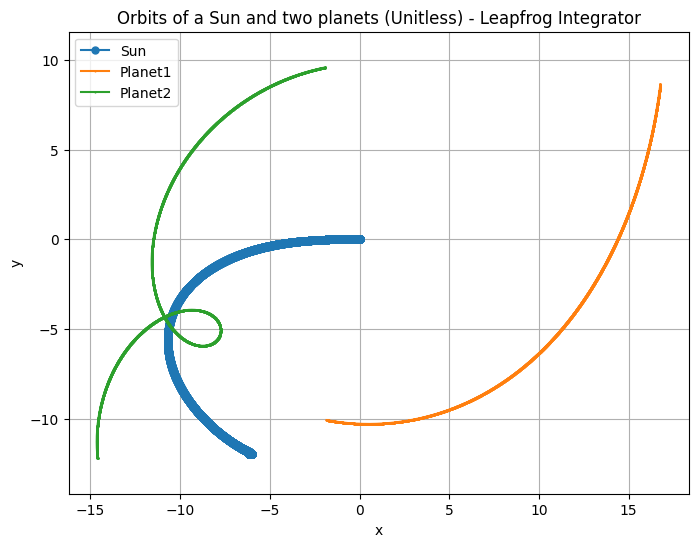

In [ ]:
orbit = orbits[1]
plt.figure(figsize=(8, 6))
plt.plot(orbit[:, 0, 0], orbit[:, 1, 0], marker=".", markersize=10, label='Sun')
plt.plot(orbit[:, 0, 1], orbit[:, 1, 1], marker=".", markersize=1, label='Planet1')
plt.plot(orbit[:, 0, 2], orbit[:, 1, 2], marker=".", markersize=1, label='Planet2')
# plt.plot(orbit[:, 0, 3], orbit[:, 1, 3], marker=".", markersize=1, label='Planet3')
# plt.plot(orbit[:, 0, 4], orbit[:, 1, 4], marker=".", markersize=1, label='Planet2')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Orbits of a Sun and two planets (Unitless) - Leapfrog Integrator')
plt.axis('equal')
plt.legend()
plt.grid(True)
plt.show()

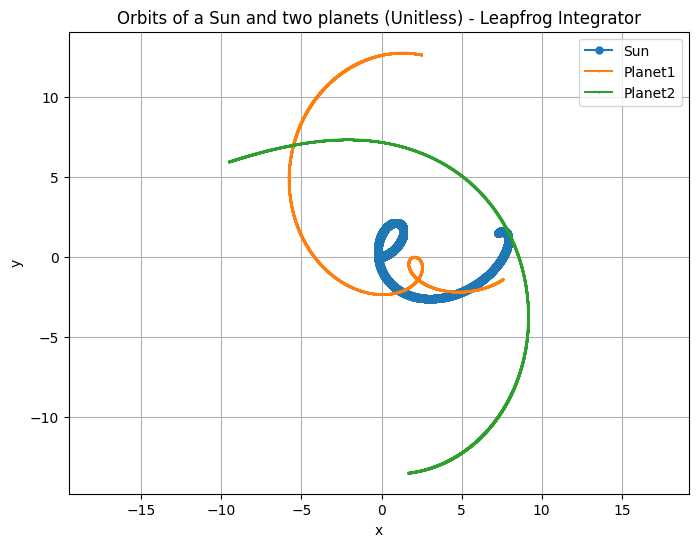

In [ ]:
orbit = orbits[2]
plt.figure(figsize=(8, 6))
plt.plot(orbit[:, 0, 0], orbit[:, 1, 0], marker=".", markersize=10, label='Sun')
plt.plot(orbit[:, 0, 1], orbit[:, 1, 1], marker=".", markersize=1, label='Planet1')
plt.plot(orbit[:, 0, 2], orbit[:, 1, 2], marker=".", markersize=1, label='Planet2')
# plt.plot(orbit[:, 0, 3], orbit[:, 1, 3], marker=".", markersize=1, label='Planet3')
# plt.plot(orbit[:, 0, 4], orbit[:, 1, 4], marker=".", markersize=1, label='Planet2')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Orbits of a Sun and two planets (Unitless) - Leapfrog Integrator')
plt.axis('equal')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
orbits.shape

(1, 1000, 4, 3)

In [ ]:
graph_data =  test.graph_dataset(orbits)

In [ ]:
element = next(iter(graph_data))

In [ ]:
element

(GraphTensor(
   context=Context(features={'time_step': <tf.Tensor: shape=(32, 1), dtype=tf.float32>}, sizes=[[1]
  [1]
  [1]
  [1]
  [1]
  [1]
  [1]
  [1]
  [1]
  [1]
  [1]
  [1]
  [1]
  [1]
  [1]
  [1]
  [1]
  [1]
  [1]
  [1]
  [1]
  [1]
  [1]
  [1]
  [1]
  [1]
  [1]
  [1]
  [1]
  [1]
  [1]
  [1]], shape=(32,), indices_dtype=tf.int32),
   node_set_names=['particles'],
   edge_set_names=['interaction']),
 <tf.Tensor: shape=(32, 3, 4), dtype=float64, numpy=
 array([[[-1.33212759e+00, -9.27890808e-01, -5.56725008e-01,
          -4.65371002e-01],
         [ 1.38713911e+01, -1.33160377e+00, -6.02921114e-01,
           2.53408064e+00],
         [-1.36172381e+01, -4.17650111e+00,  1.27514904e+00,
          -2.71383158e+00]],
 
        [[-1.65908813e+00, -1.20603910e+00, -6.58430913e-01,
          -5.69263008e-01],
         [ 1.34634166e+01,  3.35197269e-02, -9.08619764e-01,
           2.51629756e+00],
         [-1.28199315e+01, -5.61184217e+00,  1.68255359e+00,
          -2.59215650e+00]],
